- https://hackernoon.com/learn-blockchains-by-building-one-117428612f46
- http://adilmoujahid.com/posts/2018/03/intro-blockchain-bitcoin-python/
- [Blockchain Demo](https://anders.com/blockchain/blockchain.html)
- [ipynb\_playground/dumbcoin\.ipynb at master · julienr/ipynb\_playground](https://github.com/julienr/ipynb_playground/blob/master/bitcoin/dumbcoin/dumbcoin.ipynb)
- [Explaining blockchain — how proof of work enables trustless consensus](https://keepingstock.net/explaining-blockchain-how-proof-of-work-enables-trustless-consensus-2abed27f0845)
- https://bitcoin.org/bitcoin.pdf

# Transactionの実装
- 取引記録を発行することで，取引を行う

In [1]:
from dataclasses import dataclass
@dataclass
class Transaction:
    sender_address: int
    receiver_address: int
    value: float 

# Walletの実装
- addressで取引先を識別する
- とりあえず今は，Walletは適当な1つの`int`をaddressとして持つことにする
- Transactionを発行する機能をもたせる

In [2]:
@dataclass
class Wallet:
    address: int
    def send(self, receiver_address, value):
        return Transaction(self.address, receiver_address, value)

# Ledgerの実装
- transactionを記録しておく台帳を作る
- とりあえずはリストにしておく

In [3]:
Ledger=list

## Demo: シンプルな取引

In [4]:
alice=Wallet(1)
bob=Wallet(2)
ledger=Ledger()

- aliceがtransactionを発行して取引を行う

In [5]:
value=5
transaction=alice.send(2,5) # Alice send `value` to Bob
ledger.append(transaction)

- とりあえずはledgerを第三者に管理してもらうことにする
- 第三者による取引内容の書き換えはどのように防げばよいだろうか

# 公開鍵暗号(電子署名)を用いたtransactionの発行
- senderはtransactionに電子署名を行う
    - 今回はRSAを用いることにする
    - これによって第三者によるtransactionの書き換えを防ぐことができる
    - 電子署名の公開鍵はどのように扱う?
- 公開鍵をWalletのaddressとする!

## transactionの改良
- 電子署名できるようにする
    - 署名field `sign`の追加
    - データを`json`の追加

In [6]:
from typing import NamedTuple
from Crypto.Hash import SHA
from Crypto.PublicKey import RSA
import json
import dataclasses as dc

In [7]:
@dataclass
class Transaction:
    sender_address: str
    receiver_address: str
    value: float
    sign: str = None
        
    def str_data(self) -> str:
        # return the str of value without `sign`
        d=dc.asdict(self)
        del d["sign"]
        return json.dumps(d)
    
    def json_dumps(self) -> str:
        return json.dumps(dc.asdict(self))
    @classmethod
    def json_loads(cls, string) -> Transaction:
        return cls(**json.loads(string))
    
    @property
    def is_signed(self):
        return self.sign is not None

## Walletの改良
- RSAによる公開鍵 - 秘密鍵を実装する
- 簡単のためWalletはaddressを1つのみ持つことにする
    - 例えばBitCoinでは匿名性の向上のため，一つのWalletは複数のキーペアを持つことができる ([参考](https://en.bitcoin.it/wiki/Transaction))

In [8]:
from Crypto.Signature import PKCS1_v1_5
import binascii

In [9]:
def decode_key(key):
    if isinstance(key, str):
        return key
    return binascii.hexlify(key.exportKey(format='DER')).decode('ascii')
def encode_key(key):
    if isinstance(key, RSA._RSAobj):
        return key
    return RSA.importKey(binascii.unhexlify(key))

In [10]:
class Wallet:
    def __init__(self):
        key=RSA.generate(1024)
        self.private_key = decode_key(key)
        self.address = decode_key(key.publickey())
    
    def sign_transaction(self, transaction):
        signer=PKCS1_v1_5.new(encode_key(self.private_key))
        h=SHA.new(transaction.str_data().encode())
        return dc.replace(transaction, sign=signer.sign(h).hex())
    
    def send(self, receiver_address, value):
        transaction=Transaction(self.address, receiver_address, value)
        return self.sign_transaction(transaction)

In [11]:
def verify_transaction(transaction):
    if transaction.sign is None:
        return False
    h=SHA.new(transaction.str_data().encode())
    verifier=PKCS1_v1_5.new(encode_key(transaction.sender_address))
    return verifier.verify(h, binascii.unhexlify(transaction.sign))

## Demo: RSAを用いたtransactionの発行とチェック

In [12]:
alice=Wallet() # now the address is automatically generated
bob=Wallet()

In [13]:
value=5
transaction=alice.send(bob.address, value)

- check

In [14]:
verify_transaction(transaction)

True

- 第三者によるデータの改竄リスクを低減することができた 
- しかし依然として，double-spending problemを防ぐには信頼のある第三者が必要となる
- すべてのtransactionが公開されていれば，double-spendingは防げるのでは？

# Block ChainによるTransactionの公開
- いくつかのtransactionをまとめて，timestamp付き`block`で公開することを考える
    - ある特定の時間にそのtransactionが存在したことが保証される
- さらに，blockには直前のtimestampのhashを含めることにする
    - 直前の`block`が強化されることになる
- これでtransactionをチェックしてdouble-spendingを防ぐ第三者は必要なくなった
    - 今度は信頼のあるtimestampサーバが必要になったが，これは後ほど解決する

## Blockの実装
- ついでにhash関数も実装する

In [15]:
from typing import Tuple
import hashlib

In [16]:
from __future__ import annotations

In [17]:
@dataclass
class Block:
    time: float
    transactions: Tuple[Transaction]
    previous_hash: str
    sign: str = None
        
    def json_dumps(self) -> str:
        dct=dc.asdict(self)
        dct["transactions"]=[t.json_dumps() for t in self.transactions]
        return json.dumps(dct)
    
    @classmethod
    def json_loads(cls, string) -> Block:
        dct=json.loads(string)
        dct["transactions"]=tuple([Transaction.json_loads(t) for t in dct["transactions"]])
        return cls(**dct)
        
    def hash(self): 
        block_bytes=self.json_dumps().encode()
        return hashlib.sha256(block_bytes).hexdigest()

## Timestamp Serverの実装
1. transactionのリストを受け取る
2. 一つ前のblockのhashとtimestampをつけてBlockにまとめる
3. 電子署名をする
4. 公開する

## BlockChainの実装
- 公開されたBlockのhashをチェックし，chain状にBlockを保持する
- 最初のblockはprevious blockがないため，特別なブロック(genesis)を用意する
- Genesis Block
    - https://en.bitcoin.it/wiki/Genesis_block
    - BitCoinでは，ハードコードされている
    - addressも書いてあるが，そのprivate keyをSatoshi Nakamotoが持っているかは不明らしい
- 今回はただのリストにする

In [18]:
from time import time

In [19]:
class TimestampServer:
    def __init__(self):
        key=RSA.generate(1024)
        self.public_key=key.publickey()
        self.signer=PKCS1_v1_5.new(key)
        
        genesis=Block(time(), (), "0")
        self.block_chain=[genesis]
        
    def generate_block(self, transactions):
        block=Block(time(), tuple(transactions), self.block_chain[-1].hash())
        dct=dc.asdict(block)
        del dct["sign"]
        block.sign=self.signer.sign(SHA.new(json.dumps(dct).encode())).hex()
        self.block_chain.append(block)

## blockchainの正当性確認

In [20]:
def verify_block(previous_block, block, timestamp_server_publickey) -> bool:
    is_correct_hash = previous_block.hash() ==  block.previous_hash
    is_correct_transactions = all(map(verify_transaction, block.transactions))
    
    dct=dc.asdict(block)
    del dct["sign"]
    h=SHA.new(json.dumps(dct).encode())
    verifier=PKCS1_v1_5.new(timestamp_server_publickey)
    is_correct_sign=verifier.verify(h, binascii.unhexlify(block.sign))
    return is_correct_hash and is_correct_transactions and is_correct_sign

In [21]:
def verify_blockchain(chain, timestamp_server_publickey):
    for i in range(len(chain)-1):
        if not verify_block(chain[-i-2],chain[-i-1],timestamp_server_publickey):
            return False
    return True

## Demo: Timestamp server による Blockの公開とBlockChainへの登録
- timestamp serverをつくる

In [22]:
timestamp_server=TimestampServer()

- 取引

In [23]:
transactions=[]
transactions.append(alice.send(bob.address, 5))
transactions.append(bob.send(alice.address, 5))

- Block生成

In [24]:
timestamp_server.generate_block(transactions)

- 結果確認

In [25]:
verify_blockchain(timestamp_server.block_chain, timestamp_server.public_key)

True

- timestampサーバを第三者に任せない方法がほしい

# Proof-of-Workの実装
- これがblockchainの革新的技術
- block chainの正当性をtrust依存にするのではなく，cryptograph proofに基づくものにする
    - chainの暗号学的強度を高める
    - 同時にどのchainが"正しい"のか，決定するアルゴリズムも与える
- 先程は"信頼の置ける" timestamp serverの電子署名が，Blockの正当性を保証していた
- では誰でも同じ署名ができるような方法はないだろうか?
    - 電子署名でやると，当然ブロックの正当性の証明にはならない
- HashCashを用いる

 
- blockの生成を"コストの高い作業"することによって強度を高める
    - この作業によって生成された値`nonce`はblockの正当性証明となる
    - blockは1つ前のhashも持っているから，chainの途中のblockを改ざんするには，そこから先すべてのblockを改ざんする必要がある
    - blockの生成は計算コストが非常に高いから，chainの改ざんは莫大なコストを要することになる
- 最も長いchainを"正しい"chainとする
    - 最も長いchainは，もっとも多くの計算資源を投入していることになる
    - これはone-CPU-one-voteとみなせる

## blockにnonceを加える
- blockのハッシュ値が適当な条件を満たすように`nonce`を追加する
    - 例えば上4桁が0
    - この制約を"difficulty"と呼ぶ
    - difficultyは適当に調整される. 例えばbitcoinの場合は，blockの追加のintervalが10分程度になるように調整されるようだ
        - [Difficulty \- Bitcoin Wiki](https://en.bitcoin.it/wiki/Difficulty)
    - 今回はdifficultyは固定にする
- nonceを見つける作業が"mine"
    - nonceが正しいことを確認するのは簡単
    - nonceを見つけるのは難しい(総当たりで試して，あたりを引くしかない)
    - これによって"block"の生成を非常に高コストにすることができる
    - と同時に，正当性の確認にもなる
- "mine"は第三者が行う

In [26]:
@dataclass
class Block:
    time: float
    transactions: Tuple[Transaction]
    previous_hash: str
    nonce: int = None
        
    def json_dumps(self) -> str:
        dct=dc.asdict(self)
        dct["transactions"]=[t.json_dumps() for t in self.transactions]
        return json.dumps(dct)
    
    @classmethod
    def json_loads(cls, string) -> Block:
        dct=json.loads(string)
        dct["transactions"]=tuple([Transaction.json_loads(t) for t in dct["transactions"]])
        return cls(**dct)
        
    def hash(self): 
        block_bytes=self.json_dumps().encode()
        return hashlib.sha256(block_bytes).hexdigest()

## mineの実装

In [27]:
difficulty=4
def valid_proof(block):
    return block.hash()[:difficulty] == "0" * difficulty

def mine(block):
    nonce=0
    block.nonce=nonce
    while not valid_proof(block):
        nonce += 1
        block.nonce=nonce
    return block

- ついでにverify_blockも改良

In [28]:
def verify_block(previous_block, block) -> bool:
    is_correct_hash = previous_block.hash() ==  block.previous_hash
    is_correct_transactions = all(map(verify_transaction, block.transactions))
    is_correct_proof = valid_proof(block)
    return is_correct_hash and is_correct_transactions and is_correct_proof

In [29]:
class BlockChain(list):
    def json_dumps(self) -> str:
        return json.dumps([block.json_dumps() for block in self])
    @classmethod
    def json_loads(cls, string) -> BlockChain:
        return cls([Block.json_loads(s) for s in json.loads(string)])

## Demo4: tranasctionの発行からminingまで

In [30]:
genesis=Block(time(), (), "0")
block_chain=BlockChain([genesis])

# 取引
transactions=[]
transactions.append(alice.send(bob.address, 5))
transactions.append(bob.send(alice.address, 5))

- mine

In [31]:
previous_hash=block_chain[-1].hash()
block=mine(Block(time(), tuple(transactions), previous_hash))

In [32]:
block.nonce

36589

In [33]:
verify_block(block_chain[-1], block)

True

# NodeとNetwork
- 前回までで分散台帳の準備は整った
- 具体的にblockchainを保持する`node`を実装する
- 具体的なnetworkの動きは以下のようになる ([@Nakamoto2018](www.bitcoin.org))

1. transaction生成．なるべく多くのnodeにbroadcastする
2. nodeはtransactionを集めてblockにまとめる
3. mine
4. mineが終わったら，他のnodeにblockをbroadcastする
5. blockを受け取ったnodeは，blockの正当性を確認し，double-spendingのチェックをする
6. チェックが通れば，次のblockの作成を始める

- ついでにいままでのいろいろなmethodをまとめる
- 今回はbroadcastはmultiprocessのサーバープロセスを用いて模擬する
- データのやり取りはすべてjson

In [34]:
from uuid import uuid4
from time import sleep
from copy import deepcopy
import multiprocessing as mp
import random
from itertools import count

In [242]:
difficulty=3
class Node:
    def __init__(self, network, genesis, uuid=None, neighbours=None):
        self.chain=BlockChain([genesis])
        self.uuid=uuid or str(uuid4())
        self.network=network
        self.neighbours=neighbours or [self.uuid]
    
    def mine(self):
        transactions=self.network.get_transactions(self.uuid)
        if len(transactions)==0:
            return False # cannot mine due to no transactions
        previous_hash=self.chain[-1].hash()
        block=Block(time(), tuple(transactions), previous_hash)
        
        for n in self.random_generator():
            block.nonce=n
            if self.verify_proof(block):
                break
        self.broadcast_block(block)
        return True # successfully mined
    
    @staticmethod
    def random_generator(step=None):
        step = step or random.randint(1e4, 1e5)
        for c in count():
            for i in random.sample(range(c*step, (c+1)*step), step):
                yield i
        
    def add_block(self):
        for block in self.network.get_blocks(self.uuid):
            if self.verify_block(block):
                self.chain.append(block)
                if self.verify_chain(self.chain):
                    return True 
                else:
                    self.chain.pop(-1)
        return False # no block is added
    
    def broadcast_block(self, block):
        for uuid in self.neighbours:
            self.network.post_block(block, uuid)
    
    def work(self):
        while True:
            if not self.mine():
                sleep(0.1) # wait due to no transactions
            else:
                print(self.uuid, "Mined a block")
            if self.add_block():
                print(self.uuid, "Added one block")
            self.network.post_chain(self.chain, self.uuid) # publish my blockchain
            if self.resolve_conflicts():
                print(self.uuid, "Change chain")
            
    def resolve_conflicts(self):
        """Longest valid chain is authoritative"""
        authoritative_chain=self.chain
        for node_id in self.neighbours:
            chain=self.network.get_chain(node_id)
            if not self.verify_chain(chain):
                # node is incorrect
                continue
            if len(chain)>len(authoritative_chain):
                print("found long chain")
                # Longest valid chain is authoritative
                authoritative_chain=deepcopy(chain)
        self.chain=authoritative_chain
        return self.chain is not authoritative_chain
        
    @staticmethod
    def verify_transaction(transaction):
        if transaction.sign is None:
            return False
        h=SHA.new(transaction.str_data().encode())
        verifier=PKCS1_v1_5.new(encode_key(transaction.sender_address))
        return verifier.verify(h, binascii.unhexlify(transaction.sign))
    
    @staticmethod
    def verify_proof(block):
        return block.hash()[:difficulty] == "0" * difficulty
    
    def verify_block(self, block) -> bool:
        is_correct_transactions = all(map(self.verify_transaction, block.transactions))
        is_correct_proof = self.verify_proof(block)
        return is_correct_transactions and is_correct_proof
    
    def verify_chain(self, chain):
        for i in range(len(chain)-1, 0, -1):
            if not self.verify_block(chain[i]):
                return False
            if chain[i-1].hash() != chain[i].previous_hash:
                return False
        return True

- Walletもネットワーク対応に

In [210]:
class Wallet:
    def __init__(self, network):
        key=RSA.generate(1024)
        self.private_key = decode_key(key)
        self.address = decode_key(key.publickey())
        self.network=network
        self.nodes=[]
    
    def sign_transaction(self, transaction):
        signer=PKCS1_v1_5.new(encode_key(self.private_key))
        h=SHA.new(transaction.str_data().encode())
        return dc.replace(transaction, sign=signer.sign(h).hex())
    
    def send(self, receiver_address, value):
        transaction=Transaction(self.address, receiver_address, value)
        self.broadcast(self.sign_transaction(transaction))
    
    def broadcast(self, transaction):
        for uuid in self.nodes:
            self.network.post_transaction(transaction, uuid)

- networkっぽいものを実装する
    - Network classを中継点としてデータの遣り取りをする
- あとでmultiprocessでノードを動かすために，データの管理はmanagerで行う

In [211]:
from typing import List

In [212]:
class Network:
    def __init__(self):
        self.manager=mp.Manager()
        self.chains=self.manager.dict()
        self.blocks=self.manager.dict()
        self.transactions=self.manager.dict()
        
    def post_chain(self, chain, uuid):
        self.chains[uuid]=chain.json_dumps()
    
    def get_chain(self, uuid) -> BlockChain:
        if uuid not in self.chains:
            return []
        return BlockChain.json_loads(self.chains[uuid])
    
    def post_block(self, block, uuid):
        if uuid not in self.blocks:
            self.blocks[uuid]=self.manager.list([block.json_dumps()])
        else:
            self.blocks[uuid].append(block.json_dumps())
            
    def get_blocks(self, uuid) -> List[Block]:
        if uuid not in self.blocks:
            return []
        res=[Block.json_loads(s) for s in self.blocks[uuid]]
        self.blocks[uuid][:]=[]
        return res
    
    def post_transaction(self, transaction, uuid):
        if uuid not in self.transactions:
            self.transactions[uuid]=self.manager.list([transaction.json_dumps()])
        else:
            self.transactions[uuid].append(transaction.json_dumps())
            
    def get_transactions(self, uuid) -> Tuple[Transaction]:
        if uuid not in self.transactions:
            return []
        res=[Transaction.json_loads(s) for s in self.transactions[uuid]]
        self.transactions[uuid][:]=[]
        return res
    
    def shutdown(self):
        self.manager.shutdown()

In [258]:
genesis=Block(time(), (), "0")
network=Network()
alice=Wallet(network)
bob=Wallet(network)

In [259]:
def node_work(uuid, neighbours):
    node=Node(network, genesis, uuid, neighbours)
    node.neighbours=neighbours
    node.work()

In [260]:
n=5
nodes=[str(uuid4()) for _ in range(n)]

In [261]:
workers=[]
for uuid in nodes:
    worker=mp.Process(target=node_work, args=(uuid, nodes))
    workers.append(worker)
    worker.start()

2850821f-bfbb-4e66-8fb5-67f8d16521fa Mined a block
d93931ac-5e04-4497-a7c5-e2ee22bf415c Mined a block
2850821f-bfbb-4e66-8fb5-67f8d16521fa Added one block
d93931ac-5e04-4497-a7c5-e2ee22bf415c Added one block
13dad767-d4ea-4c90-9dad-107d93bf8901 Mined a block
bb94e075-35a2-4a5c-9e22-157693794f07 Mined a block
13dad767-d4ea-4c90-9dad-107d93bf8901 Added one block
bb94e075-35a2-4a5c-9e22-157693794f07 Added one block
d93931ac-5e04-4497-a7c5-e2ee22bf415c Mined a block
d93931ac-5e04-4497-a7c5-e2ee22bf415c Added one block
bb94e075-35a2-4a5c-9e22-157693794f07 Added one block
13dad767-d4ea-4c90-9dad-107d93bf8901 Added one block
found long chain
55265a39-c173-4f07-96f4-95b0dad346d3 Mined a block
55265a39-c173-4f07-96f4-95b0dad346d3 Added one block
found long chain
2850821f-bfbb-4e66-8fb5-67f8d16521fa Mined a block
2850821f-bfbb-4e66-8fb5-67f8d16521fa Added one block
d93931ac-5e04-4497-a7c5-e2ee22bf415c Added one block
13dad767-d4ea-4c90-9dad-107d93bf8901 Mined a block
13dad767-d4ea-4c90-9dad-107d

In [262]:
alice.nodes=nodes[0:2]
bob.nodes=nodes[1:3]

In [263]:
taro=Wallet(network)
taro.nodes=nodes

In [264]:
taro.send(alice.address, 13)
bob.send(alice.address, 10)
alice.send(bob.address, 5)

In [266]:
taro.send(alice.address, 10)

In [257]:
for worker in workers:
    worker.terminate()
network.shutdown()

# blockchain check

In [223]:
import networkx as nx

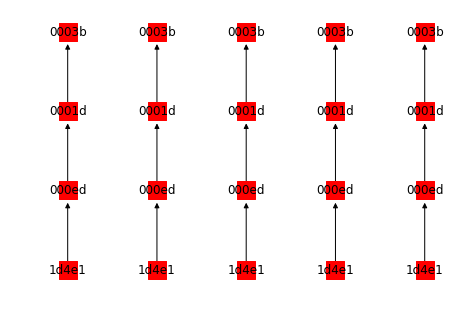

In [267]:
g=nx.DiGraph()
pos={}
label={}
group={}
for j, (k, v) in enumerate(network.chains.items()):
    chain=BlockChain.json_loads(v)
    h=list(map(lambda x: x.hash()[:5], chain))
    nodes=[f"{k}_{i}" for i in range(len(h))]
    for i in range(len(h)):
        node=f"{k}_{i}"
        pos[node]=(j,i)
        label[node]= h[i]
        group[node]=j
    g.add_nodes_from(nodes)
    for i in range(len(h)-1):
        g.add_edge(f"{k}_{i}",f"{k}_{i+1}",)

nx.draw(g, labels=label, pos=pos, node_shape="s")